<a href="https://colab.research.google.com/github/hydmic009/CS3001F-A1/blob/main/Textbook_active2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Step 1: Establishing Performance Baselines ---
Accuracy with 50 random labels (Naive Baseline): 0.7582
Accuracy with full training set (Fully Supervised Benchmark): 0.9093

--- Step 2: Running the Semi-Supervised Learning Pipeline ---
Improvement 1: Accuracy with 50 representative labels: 0.8388
Improvement 2: Accuracy after propagating labels to all samples: 0.8589
Improvement 3: Accuracy after removing outliers: 0.8564

--- Displaying the 50 Representative Images Chosen for Labeling ---


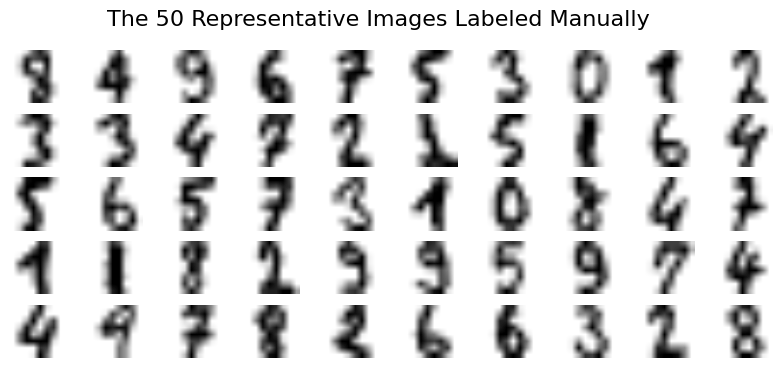

--- Generating Final Performance Comparison Graph ---


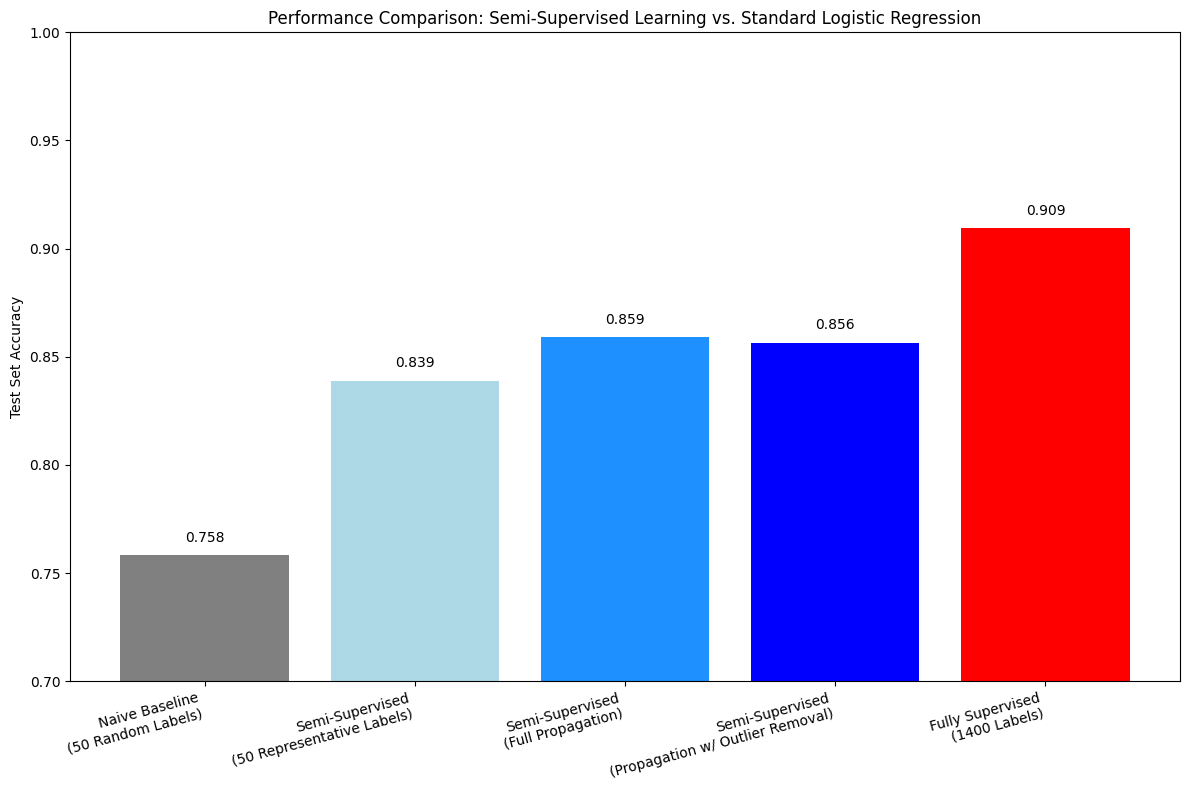

In [2]:
# 1. SETUP AND IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

# 2. LOAD DATA AND CREATE SPLITS
X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]
n_labeled = 50

# 3. ESTABLISH PERFORMANCE BENCHMARKS
print("--- Step 1: Establishing Performance Baselines ---")

# Benchmark 1: Model with only 50 randomly chosen labels (Naive Approach)
log_reg_random = LogisticRegression(max_iter=10_000)
log_reg_random.fit(X_train[:n_labeled], y_train[:n_labeled])
random_baseline_score = log_reg_random.score(X_test, y_test)
print(f"Accuracy with {n_labeled} random labels (Naive Baseline): {random_baseline_score:.4f}")

# Benchmark 2: Fully supervised model on the whole training set (Gold Standard)
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
full_supervised_score = log_reg_full.score(X_test, y_test)
print(f"Accuracy with full training set (Fully Supervised Benchmark): {full_supervised_score:.4f}\n")


# 4. SEMI-SUPERVISED METHOD: CLUSTERING AND LABEL PROPAGATION
print("--- Step 2: Running the Semi-Supervised Learning Pipeline ---")

# Cluster the training set to find 50 representative images
k = 50
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

# Manually label these 50 representative images
# NOTE: Using the correct labels you provided that match the image visualization
y_representative_digits = np.array([
    8, 4, 9, 6, 7, 5, 3, 0, 1, 2,
    3, 3, 4, 7, 2, 1, 5, 1, 6, 4,
    5, 6, 5, 7, 3, 1, 0, 8, 4, 7,
    1, 1, 8, 2, 9, 9, 5, 9, 7, 4,
    4, 9, 7, 8, 2, 6, 6, 3, 2, 8
])

# Train a model on ONLY the 50 representative labels
log_reg_representative = LogisticRegression(max_iter=10_000)
log_reg_representative.fit(X_representative_digits, y_representative_digits)
representative_score = log_reg_representative.score(X_test, y_test)
print(f"Improvement 1: Accuracy with {n_labeled} representative labels: {representative_score:.4f}")

# Propagate the representative labels to all other instances in their respective clusters
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

log_reg_propagated = LogisticRegression(max_iter=10_000)
log_reg_propagated.fit(X_train, y_train_propagated)
propagated_score = log_reg_propagated.score(X_test, y_test)
print(f"Improvement 2: Accuracy after propagating labels to all samples: {propagated_score:.4f}")

# Refine by removing the 1% of instances in each cluster that are farthest from the centroid
percentile_closest = 99
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated_mask = (X_cluster_dist != -1)
X_train_final = X_train[partially_propagated_mask]
y_train_final = y_train_propagated[partially_propagated_mask]

log_reg_final = LogisticRegression(max_iter=10_000)
log_reg_final.fit(X_train_final, y_train_final)
final_score = log_reg_final.score(X_test, y_test)
print(f"Improvement 3: Accuracy after removing outliers: {final_score:.4f}\n")


# 5. VISUALIZE THE RESULTS

# First, show the 50 representative images that were selected for labeling
print("--- Displaying the 50 Representative Images Chosen for Labeling ---")
plt.figure(figsize=(10, 4))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')
plt.suptitle("The 50 Representative Images Labeled Manually", fontsize=16)
plt.show()


# Second, create a bar chart to compare the performance at each stage
print("--- Generating Final Performance Comparison Graph ---")
plt.figure(figsize=(12, 8))

# Define the models and their scores
model_names = [
    f'Naive Baseline\n({n_labeled} Random Labels)',
    f'Semi-Supervised\n({n_labeled} Representative Labels)',
    'Semi-Supervised\n(Full Propagation)',
    'Semi-Supervised\n(Propagation w/ Outlier Removal)',
    'Fully Supervised\n(1400 Labels)'
]
scores = [
    random_baseline_score,
    representative_score,
    propagated_score,
    final_score,
    full_supervised_score
]
colors = ['gray', 'lightblue', 'dodgerblue', 'blue', 'red']

# Create the bar plot
bars = plt.bar(model_names, scores, color=colors)
plt.ylabel('Test Set Accuracy')
plt.title('Performance Comparison: Semi-Supervised Learning vs. Standard Logistic Regression')
plt.ylim(0.7, 1.0) # Focus on the relevant accuracy range
plt.xticks(rotation=15, ha="right")

# Add accuracy values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()